# Automated Bias Triangle Detection, Approximation & Feature Extraction Framework

The following script detects & fits bias triangles in voltage maps & extracts their features. As the shape to be detected can be easily characterized as having three vertices, we resort to polygon-based algorithms.

High intensity regions are interpolated, before basic contour detection (as per automated intensity thresholding) is applied. Subsequently, the contours are approximated by triangles in two distinct ways: 

1. Polygons with a reduced number of vertices are determined (based on an implementation of the Ramer-Douglas-Peucker (RDP) algorithm) 
    
2. The minimum enclosing triangles (of the convex hull of intensity points) are determined   

Specifically, a relaxed version of 1. is used to segment the triangle, while 2. is employed in further feature extraction.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os
import cv2 as cv

In [2]:
b_triangles = []
for file_name in os.listdir('data_from_basel_nanowire/PSB-Examples/'):
    try:
        d = np.loadtxt('data_from_basel_nanowire/PSB-Examples/'+file_name, skiprows = 3)
        b_triangles.append(d[:, 1:])
        plt.figure(figsize(12,12))
        plt.imshow(d[:, 1:])
        plt.show()
    except:
        print(f'did not work for {file_name}')

did not work for Iylocc2q4_20846.txt
did not work for Iylocc2q4_20847.txt
did not work for log_for_8688.txt
did not work for Ic2c4_8688.txt
did not work for Ic2c4_8689.txt
did not work for log_for_8689.txt
did not work for Ixlocc2q4_20847.txt
did not work for log_for_8767.txt
did not work for Ic2c4_8767.txt
did not work for Ixlocc2q4_20846.txt
did not work for Ic2c4_8759.txt
did not work for log_for_8759.txt
did not work for log_for_8764.txt
did not work for Ic2c4_8764.txt
did not work for Ic2c4_8760.txt
did not work for log_for_8760.txt
did not work for log_for_8749.txt
did not work for Ic2c4_8749.txt
did not work for Ic2q4_20847.txt
did not work for Ic2q4_20846.txt
did not work for log_for_20847.txt
did not work for log_for_8754.txt
did not work for log_for_20846.txt
did not work for Ic2c4_8754.txt
did not work for Ic2c4_8742.txt
did not work for log_for_8742.txt
did not work for log_for_8687.txt
did not work for Ic2c4_8687.txt
did not work for Ic2c4_8692.txt
did not work for log_for

1. Given a sample scan, we begin by detecting & approximating triangles using a relaxation of the RDP, resulting in a pixelwise segmentation mask

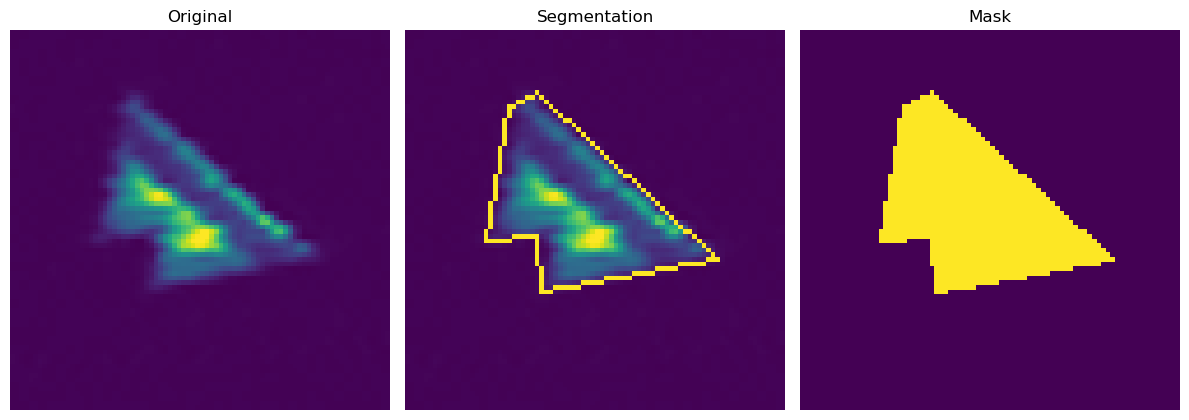

In [3]:
import btriangle_detection


gray_orig, ims, masks = btriangle_detection.triangle_segmentation_alg(b_triangles[7],res = 2,min_area = 3, thr_method = 'triangle')

fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(12, 12),sharex=True, sharey=True)

ax[0].imshow(gray_orig) 
ax[0].axis('off') 
ax[0].set_title('Original') 

ax[1].imshow(ims[0]) 
ax[1].axis('off') 
ax[1].set_title('Segmentation') 

ax[2].imshow(masks) 
ax[2].axis('off') 
ax[2].set_title('Mask') 

fig.tight_layout()
plt.show() 

2.1 Feature Extraction: Given a user-specified direction ('up','down','right','left), determine the base line and angles 

The angles (as per MET) in degrees are  [52.83406161275929, 59.59276925568558, 67.57316913155513]


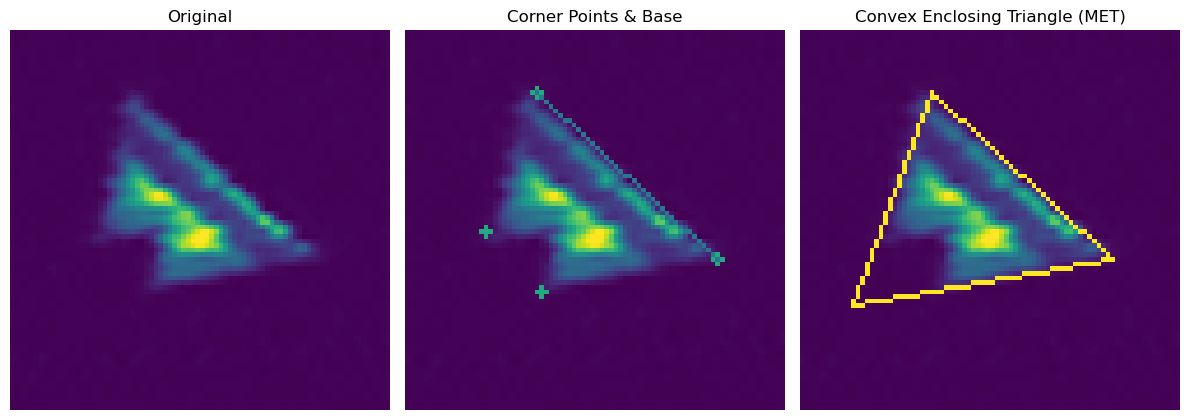

In [4]:
import btriangle_properties

base, corner_pts, c_im = btriangle_properties.detect_base(gray_orig, masks, 'down')
angles, angl_img = btriangle_properties.compute_angles(gray_orig, np.array(corner_pts), 'MET')

print('The angles (as per MET) in degrees are ', angles)

fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(12, 12),sharex=True, sharey=True)

ax[0].imshow(gray_orig) 
ax[0].axis('off') 
ax[0].set_title('Original') 

ax[1].imshow(c_im) 
ax[1].axis('off') 
ax[1].set_title('Corner Points & Base') 

ax[2].imshow(angl_img) 
ax[2].axis('off') 
ax[2].set_title('Convex Enclosing Triangle (MET)') 

fig.tight_layout()
plt.show() 

2.2 Feature Extraction: 
Detect further lines within the triangle (parallel to the base), which belong to excited states, using a Fast Line Detector (FLD). 

As per further constraints, select the line of interest and determine the mean intensity of the triangle segment between the former and the base. Further, detect the detuning axes.

The mean intensity of the segment is 57.236577181208055 while the mean intensity of the triangle is 73.19930675909879


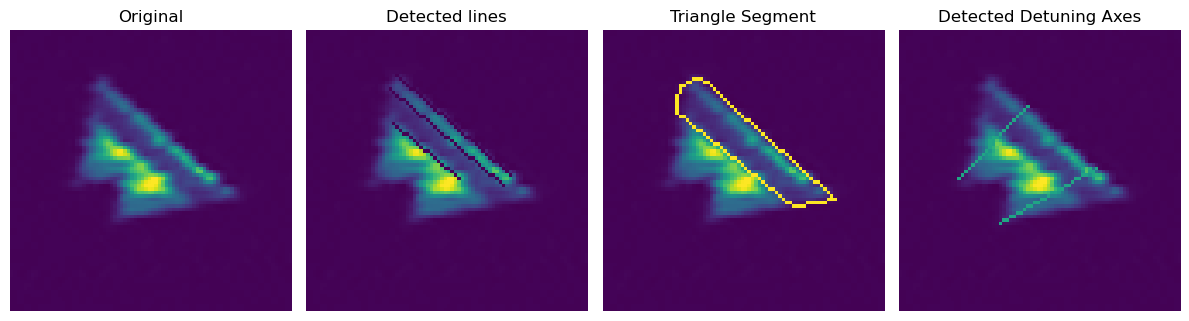

In [7]:
exc_state, line_mask = btriangle_properties.get_excited_state(gray_orig, base,'down', tol = 0.3)
ex_line = exc_state[2]

contour, _ = cv.findContours(masks,cv.RETR_TREE,cv.CHAIN_APPROX_SIMPLE)
intersection = btriangle_properties.extract_triangle_seg(gray_orig, base, ex_line, contour[0])
_, _ , tr_int = btriangle_properties.extract_props(intersection, gray_orig)

_, _ , tr_int_all = btriangle_properties.extract_props(contour[0], gray_orig)

blank = gray_orig.copy()
seg_im = cv.drawContours(blank, [intersection], -1,(255,0,255), thickness=1)

axes_points,axes,line_img = btriangle_properties.detect_detuning_axis(gray_orig, base, corner_pts)

print('The mean intensity of the segment is', tr_int, 'while the mean intensity of the triangle is', tr_int_all)

fig, ax = plt.subplots(nrows=1, ncols=4, figsize=(12, 12),sharex=True, sharey=True)

ax[0].imshow(gray_orig) 
ax[0].axis('off') 
ax[0].set_title('Original') 

ax[1].imshow(line_mask) 
ax[1].axis('off') 
ax[1].set_title('Detected lines') 

ax[2].imshow(seg_im) 
ax[2].axis('off') 
ax[2].set_title('Triangle Segment')

ax[3].imshow(line_img) 
ax[3].axis('off') 
ax[3].set_title('Detected Detuning Axes')

fig.tight_layout()
plt.show() 